In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose

# Set visualization style
sns.set(style="whitegrid")

# Load Data
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")


In [2]:
# ---------------------------- Data Exploration ----------------------------
# Examine data structure
print("Customers dataset:\n", customers.info(), "\n")
print("Products dataset:\n", products.info(), "\n")
print("Transactions dataset:\n", transactions.info(), "\n")

# Preview the data
print(customers.head(), "\n")
print(products.head(), "\n")
print(transactions.head(), "\n")

# Check for missing values
print("Missing values in Customers:\n", customers.isnull().sum(), "\n")
print("Missing values in Products:\n", products.isnull().sum(), "\n")
print("Missing values in Transactions:\n", transactions.isnull().sum(), "\n")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
Customers dataset:
 None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
Products dataset:
 None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  D

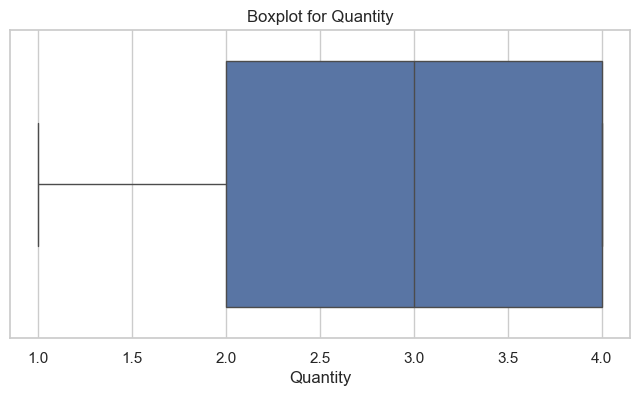

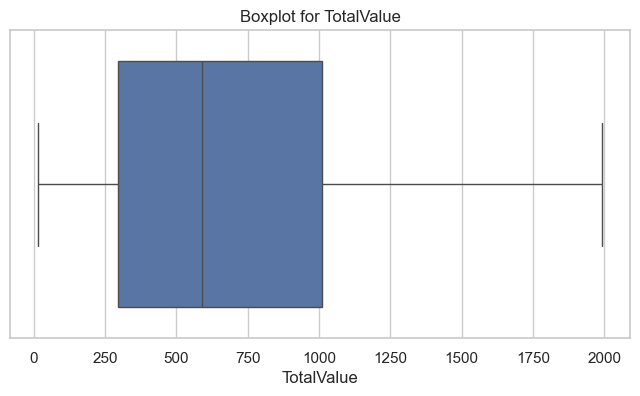

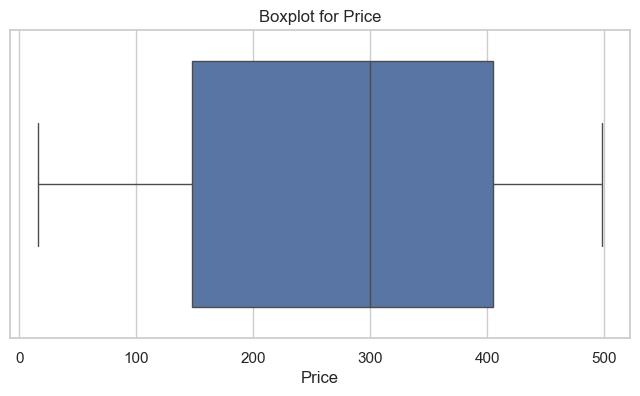

In [3]:
# Handle missing values (example: drop rows with missing values)
customers.dropna(inplace=True)
products.dropna(inplace=True)
transactions.dropna(inplace=True)

# Check for outliers in numerical columns (e.g., boxplot)
for column in transactions.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=transactions[column])
    plt.title(f"Boxplot for {column}")
    plt.show()

/var/folders/8d/bv4wc5wd00v4w54lkxlpbrrc0000gn/T/ipykernel_7359/48578323.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_counts.index, y=region_counts.values, palette="viridis")


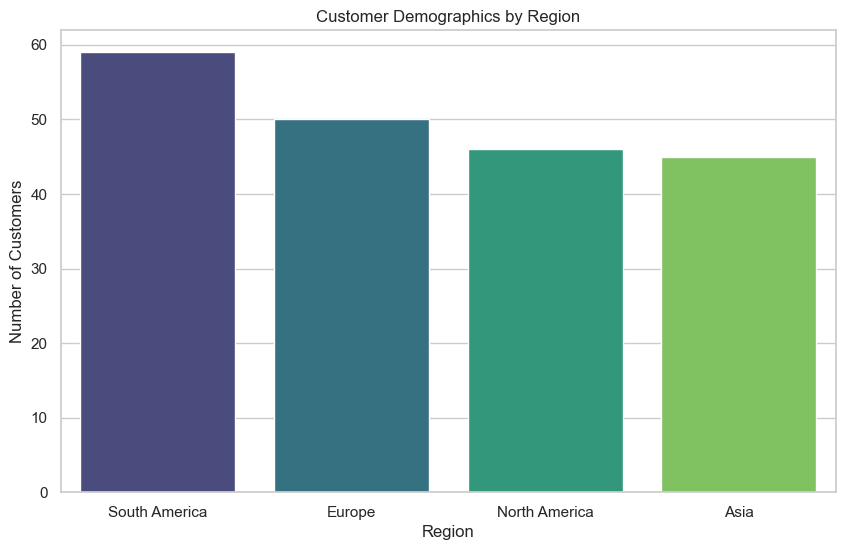

In [4]:
# ---------------------------- Data Analysis ----------------------------
# Customer demographics by region
region_counts = customers['Region'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=region_counts.index, y=region_counts.values, palette="viridis")
plt.title("Customer Demographics by Region")
plt.ylabel("Number of Customers")
plt.xlabel("Region")
plt.show()



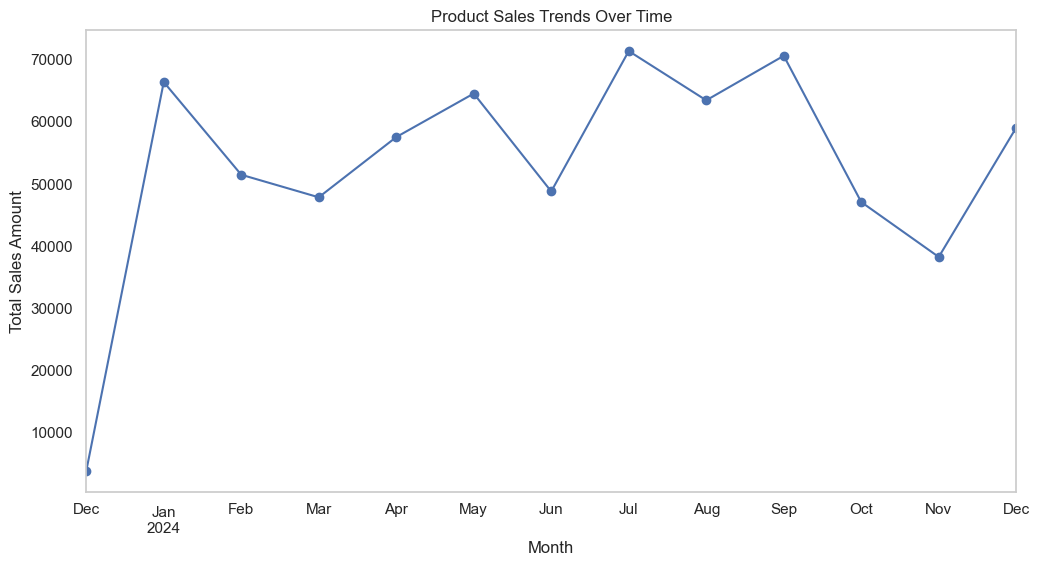

In [5]:
# Product sales trends over time
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
transactions['Month'] = transactions['TransactionDate'].dt.to_period('M')
sales_trends = transactions.groupby('Month')['TotalValue'].sum()
plt.figure(figsize=(12, 6))
sales_trends.plot(kind='line', marker='o', color='b')
plt.title("Product Sales Trends Over Time")
plt.ylabel("Total Sales Amount")
plt.xlabel("Month")
plt.grid()
plt.show()

/var/folders/8d/bv4wc5wd00v4w54lkxlpbrrc0000gn/T/ipykernel_7359/887634673.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TotalValue', y='ProductName', data=top_products, palette="magma")


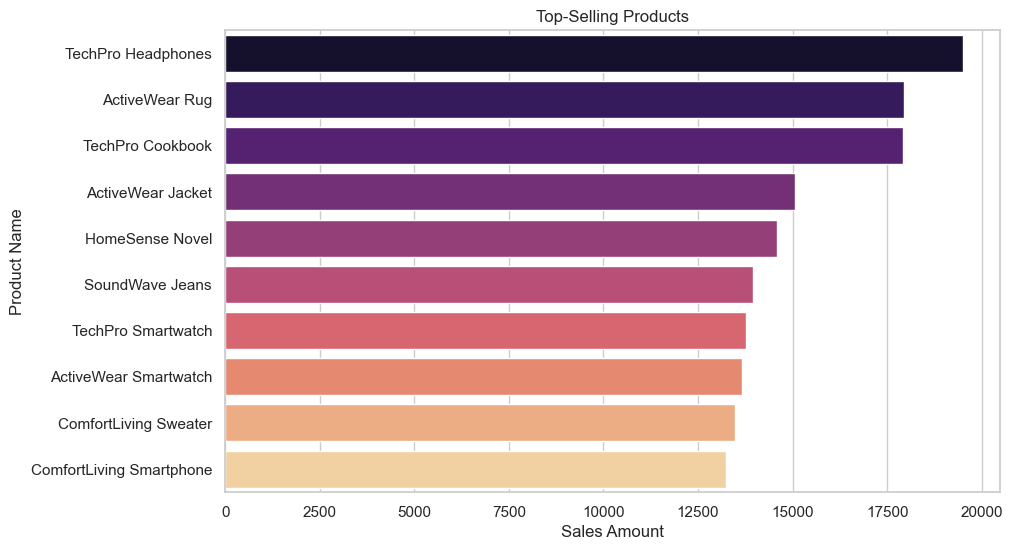

In [6]:
# Top-selling products and categories
top_products = transactions.groupby('ProductID')['TotalValue'].sum().nlargest(10)
top_products = top_products.reset_index().merge(products, on='ProductID')
plt.figure(figsize=(10, 6))
sns.barplot(x='TotalValue', y='ProductName', data=top_products, palette="magma")
plt.title("Top-Selling Products")
plt.xlabel("Sales Amount")
plt.ylabel("Product Name")
plt.show()

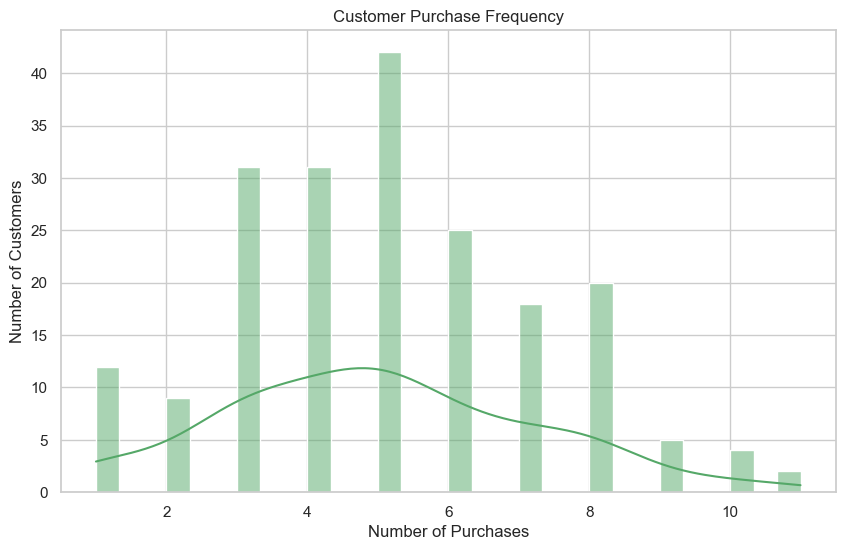

In [7]:
# Customer purchase patterns
purchase_counts = transactions['CustomerID'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(purchase_counts, bins=30, kde=True, color='g')
plt.title("Customer Purchase Frequency")
plt.xlabel("Number of Purchases")
plt.ylabel("Number of Customers")
plt.show()

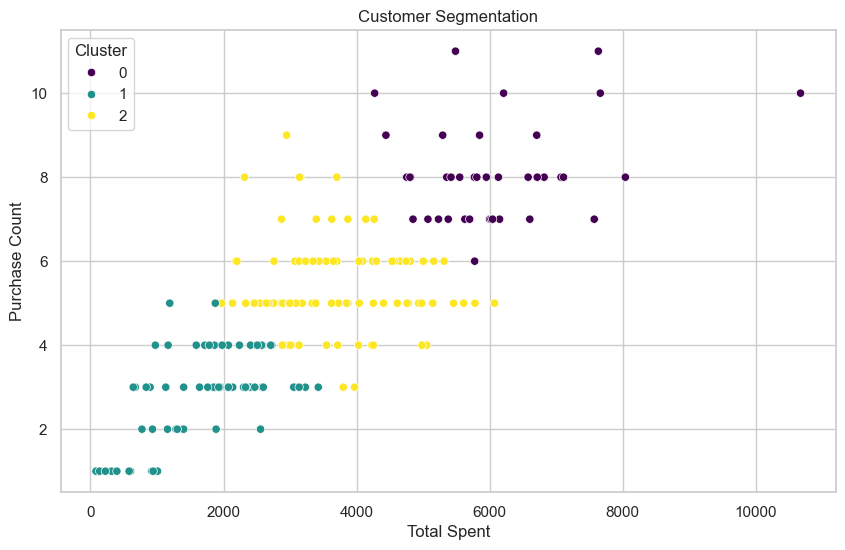

In [8]:
# ---------------------------- Predictive Modeling ----------------------------
# 1. Customer Segmentation using K-Means
customer_data = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count'
}).rename(columns={'TotalValue': 'TotalSpent', 'TransactionID': 'PurchaseCount'})

# Scale the data and retain the index
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data)
scaled_data = pd.DataFrame(scaled_data, index=customer_data.index, columns=['TotalSpent_scaled', 'PurchaseCount_scaled'])

# Fit the KMeans model
kmeans = KMeans(n_clusters=3, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_data)

# Plot the results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=customer_data['TotalSpent'], y=customer_data['PurchaseCount'], hue=customer_data['Cluster'], palette="viridis")
plt.title("Customer Segmentation")
plt.xlabel("Total Spent")
plt.ylabel("Purchase Count")
plt.show()



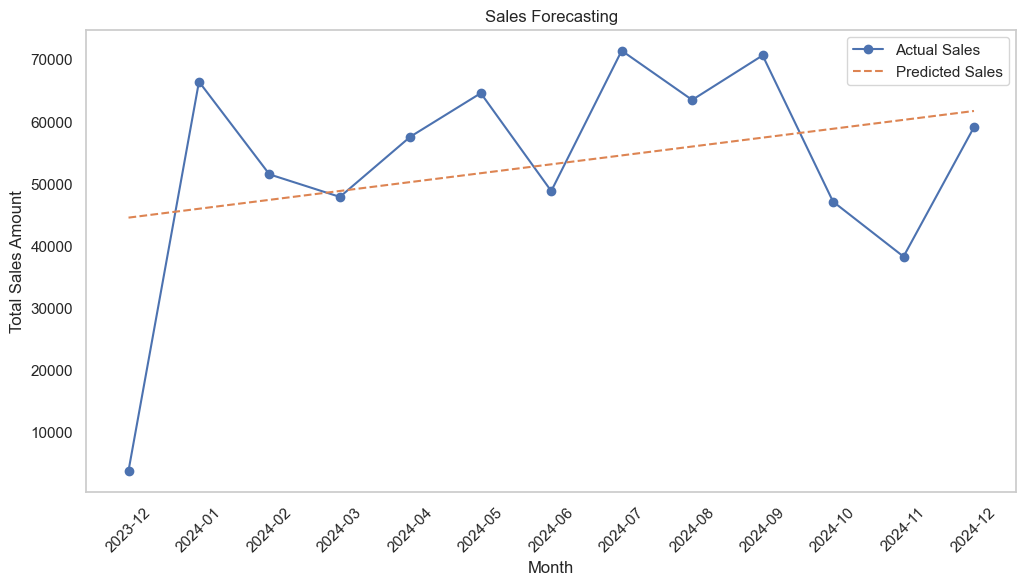

In [9]:
# 2. Sales Forecasting using Linear Regression
monthly_sales = transactions.groupby('Month')['TotalValue'].sum().reset_index()
monthly_sales['Month'] = monthly_sales['Month'].astype(str)
monthly_sales['Time'] = np.arange(len(monthly_sales))

X = monthly_sales[['Time']]
y = monthly_sales['TotalValue']
model = LinearRegression()
model.fit(X, y)

monthly_sales['PredictedSales'] = model.predict(X)
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['Month'], monthly_sales['TotalValue'], label="Actual Sales", marker='o')
plt.plot(monthly_sales['Month'], monthly_sales['PredictedSales'], label="Predicted Sales", linestyle='--')
plt.xticks(rotation=45)
plt.title("Sales Forecasting")
plt.ylabel("Total Sales Amount")
plt.xlabel("Month")
plt.legend()
plt.grid()
plt.show()